In [1]:
from __future__ import division
import numpy as np
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import graphlab

In [2]:
#balanced accuracy
def Balanced_acc(ypred,ytest):
    acc_c = 0
    acc_class = np.zeros(5) #the accuracy per class
    for c in np.unique(ytest):
        i = ytest == c
        correct = ypred[i] == ytest[i]
        acc_c += sum(correct)/len(correct)
        acc_class[c] = sum(correct)/len(correct)

    Bacc = acc_c/len(np.unique(ytest))
    return Bacc,acc_class

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'], rotation=45)
    plt.yticks(tick_marks, ['Sit','StairsUp','StairsDw','Stand','Walk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def prec_rec(cmat):
    tpfp = cmat.sum(axis=1)
    tpfn = cmat.sum(axis=0)
    prec = cmat.diagonal()/tpfp
    recall = cmat.diagonal()/tpfn
    return prec,recall

### Load Data

In [370]:
HealthyData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/HealthyData.csv',verbose=False)
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv',verbose=False)
SCOData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientSCOData.csv',verbose=False)

In [262]:
HealthyCodes = HealthyData['SubjID'].unique()
HealthyCodes = HealthyCodes.sort()
print HealthyCodes
PatientCodes = CBRData['SubjID'].unique()
PatientCodes = PatientCodes.sort()
print PatientCodes

[51L, 52L, 53L, 54L, 55L, 56L, 57L, 58L, 59L, 60L, 61L]
[1L, 2L, 5L, 6L, 8L, 11L, 12L, 13L, 14L, 15L, 16L, 19L]


In [263]:
PatientCodes = np.array([1, 2, 5, 6, 8, 11, 14, 15, 16, 19]) #all patients with 4 sessions in CBR

### Optional: Remove stair climbing from patients who don't have stairs in all CBR sessions
* Following patients don't have stairs in all 4 sessions (08,11,14,15,19)

In [264]:
Nostairs = [8,11,14,15,19]

In [265]:
CBRDatanew = CBRData.filter_by(Nostairs,'SubjID',exclude=True)
for s in Nostairs:
    data = CBRData[(CBRData['SubjID']==s)].filter_by([0,3,4],'Label')
    CBRDatanew=CBRDatanew.append(data)

for s in PatientCodes:
    print s,CBRDatanew[CBRDatanew['SubjID']==s]['Label'].unique().sort()

1 [0L, 1L, 2L, 3L, 4L]
2 [0L, 1L, 2L, 3L, 4L]
5 [0L, 1L, 2L, 3L, 4L]
6 [0L, 1L, 2L, 3L, 4L]
8 [0L, 3L, 4L]
11 [0L, 3L, 4L]
14 [0L, 3L, 4L]
15 [0L, 3L, 4L]
16 [0L, 1L, 2L, 3L, 4L]
19 [0L, 3L, 4L]


In [269]:
print CBRData.num_rows()
print CBRDatanew.num_rows()

22354
21974


In [34]:
CBRData = CBRDatanew

### Check sessions in which patients have stairs for SCO data

In [372]:
for s in PatientCodes:
    data = SCOData[SCOData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 3 4]
2 4 [0 1 2 3 4]
5 1 [0 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 1 2 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 3 4]
11 1 [0 3 4]
11 2 [0 3 4]
11 3 [0 3 4]
11 4 [0 1 2 3 4]
14 1 [0 1 2 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 1 2 3 4]
19 3 [0 3 4]


### Use 3 sessions from SCO Data (to make it comparable with CBR Data)
* CBR02 Remove Session 3 
* CBR08 Remove Session 1
* CBR11 Remove Session 1
* CBR16 Remove Session 2
* CBR19 Remove Stairs 

In [335]:
print SCOData.num_rows()

18762


In [336]:
tochange = [2,8,11,16]
SCODatanew = SCOData.filter_by(tochange,'SubjID',exclude=True)

In [337]:
def updatesess(x):
    if x > 2:
        x = x-1
        return x
    else:
        return x

In [338]:
data = SCOData[(SCOData['SubjID']==2) & (SCOData['Session']!=3)]
data['Session'] = data['Session'].apply(updatesess) #rename sessions to 1,2,3
SCODatanew=SCODatanew.append(data)

data = SCOData[((SCOData['SubjID']==8) | (SCOData['SubjID']==11)) & (SCOData['Session']!=1)]
data['Session'] = data['Session'].apply(lambda x: x-1) #rename sessions to 1,2,3
SCODatanew=SCODatanew.append(data)

data = SCOData[(SCOData['SubjID']==16) & (SCOData['Session']!=2)]
data['Session'] = data['Session'].apply(updatesess) #rename sessions to 1,2,3
SCODatanew=SCODatanew.append(data)

#data = SCOData[SCOData['SubjID']==19].filter_by([1,2],'Label',exclude=True)
#SCODatanew=SCODatanew.append(data)

In [339]:
SCODatanew = SCODatanew.filter_by(4,'Session',exclude=True)
print SCODatanew.num_rows()

15877


In [356]:
for s in PatientCodes:
    data = SCODatanew[SCODatanew['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
5 1 [0 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
11 1 [0 3 4]
11 2 [0 3 4]
11 3 [0 1 2 3 4]
14 1 [0 1 2 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 1 2 3 4]
19 3 [0 3 4]


In [357]:
SCOData = SCODatanew

### Check sessions in which patients have stairs for CBR data

In [373]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
2 4 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
5 4 [0 1 2 3 4]
6 1 [0 1 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 1 2 3 4]
11 1 [0 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
11 4 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 1 2 3 4]
15 3 [0 3 4]
15 4 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]
19 4 [0 3 4]


## Train RF on healthy 

In [13]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=100)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject


k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)  & (CBRData['Session'] != 4)] #keep out one session (used later for target)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array

    print 'Test on Patient %s'%s
    print 'Train samples = %s, Test samples = %s'%(len(ytrain),len(ytest))
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

Test on Patient 1
Train samples = 8375, Test samples = 1288
BAcc = 0.48
Test on Patient 2
Train samples = 8375, Test samples = 991
BAcc = 0.35
Test on Patient 5
Train samples = 8375, Test samples = 1358
BAcc = 0.43
Test on Patient 6
Train samples = 8375, Test samples = 2035
BAcc = 0.56
Test on Patient 8
Train samples = 8375, Test samples = 856
BAcc = 0.34
Test on Patient 11
Train samples = 8375, Test samples = 1195
BAcc = 0.63
Test on Patient 14
Train samples = 8375, Test samples = 1599
BAcc = 0.77
Test on Patient 15
Train samples = 8375, Test samples = 1860
BAcc = 0.64
Test on Patient 16
Train samples = 8375, Test samples = 1126
BAcc = 0.53
Test on Patient 19
Train samples = 8375, Test samples = 1020
BAcc = 0.57

median Bacc - Healthy model = 0.543412793486


## Global model SCO (Leave one subject out)

In [16]:
ISpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Impairment specific (SCO) model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.58
Patient 2, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.49
Patient 5, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.49
Patient 6, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.56
Patient 8, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.49
Patient 11, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.88
Patient 14, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.96
Patient 15, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.97
Patient 16, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.54
Patient 19, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.89
Median BAcc - Impairment Specific (SCO) = 0.569763931298


## Global model CBR (Leave one subject out)

In [18]:
ISpecCBR_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = CBRData[(CBRData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100,random_state=0)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpecCBR_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Global CBR model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpecCBR_acc[k])
    k = k+1

print 'Median BAcc - Global CBR model = %s'%np.median(ISpecCBR_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.57
Patient 2, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.47
Patient 5, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.52
Patient 6, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.52
Patient 8, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.62
Patient 11, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.94
Patient 14, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.90
Patient 15, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.96
Patient 16, Nclass train = 5, Nclass test = 5, Global CBR model - BAcc = 0.55
Patient 19, Nclass train = 5, Nclass test = 3, Global CBR model - BAcc = 0.89
Median BAcc - Global CBR model = 0.594961923874


## Train on SCO and test on CBR (Patient Specific model) 

In [19]:
PSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Personal model (Trained on SCO) - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.70
Patient 2, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.50
Patient 5, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.65
Patient 6, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.55
Patient 8, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.72
Patient 11, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.77
Patient 14, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.67
Patient 15, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.70
Patient 16, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.46
Patient 19, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.72
Median BAcc - Patient Specific (SCO) = 0.685131303259


## Patient and Device specific model (CBR)
* Leave One Session Out of CBR 
* Keep out 1 session (#4) for target

In [20]:
DSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    data =  CBRData[(CBRData['SubjID'] == s) & (CBRData['Session'] != 4)] #keep out 1 session for target
    Bacc = np.zeros(3)
    for session in range(1,4):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(Nclasstrain,Nclasses,Bacc[session-1])

    DSpec_acc[k] = Bacc.mean() #the CV BAcc on 3 sessions 
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%np.median(DSpec_acc)

Nclass train = 5, Nclass test =5, BAcc = 0.74
Nclass train = 5, Nclass test =5, BAcc = 0.83
Nclass train = 5, Nclass test =5, BAcc = 0.84
Patient 1, Device Specific model - BAcc = 0.80
Nclass train = 5, Nclass test =5, BAcc = 0.76
Nclass train = 5, Nclass test =5, BAcc = 0.54
Nclass train = 5, Nclass test =5, BAcc = 0.74
Patient 2, Device Specific model - BAcc = 0.68
Nclass train = 5, Nclass test =5, BAcc = 0.74
Nclass train = 5, Nclass test =5, BAcc = 0.55
Nclass train = 5, Nclass test =5, BAcc = 0.54
Patient 5, Device Specific model - BAcc = 0.61
Nclass train = 5, Nclass test =4, BAcc = 0.67
Nclass train = 5, Nclass test =5, BAcc = 0.56
Nclass train = 5, Nclass test =5, BAcc = 0.57
Patient 6, Device Specific model - BAcc = 0.60
Nclass train = 3, Nclass test =3, BAcc = 0.94
Nclass train = 3, Nclass test =3, BAcc = 0.74
Nclass train = 3, Nclass test =3, BAcc = 0.72
Patient 8, Device Specific model - BAcc = 0.80
Nclass train = 3, Nclass test =3, BAcc = 0.96
Nclass train = 3, Nclass test

In [21]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.47758938  0.58300463  0.70342103  0.80065951]
 [ 0.35029695  0.48956648  0.49541041  0.68050187]
 [ 0.43394698  0.49400206  0.64852425  0.60865318]
 [ 0.55510352  0.55652323  0.5454451   0.60196907]
 [ 0.33926679  0.49450527  0.71957323  0.80221301]
 [ 0.6309931   0.87945728  0.77391697  0.84481914]
 [ 0.77345279  0.96036909  0.67213272  0.9728358 ]
 [ 0.64032509  0.96663455  0.69812989  0.96886686]
 [ 0.53172207  0.54170888  0.46269905  0.69948181]
 [ 0.57449632  0.88612574  0.71742539  0.77044634]]


<function matplotlib.pyplot.show>

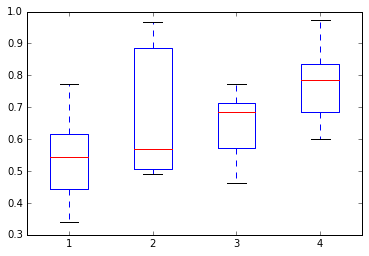

In [22]:
plt.boxplot(acc_all)
plt.show

In [23]:
np.median(SOacc)

0.54341279348643956

In [24]:
np.median(ISpec_acc)

0.56976393129780567

In [25]:
np.median(PSpec_acc)

0.6851313032590568

In [26]:
np.median(DSpec_acc)

0.78555292880846217

In [27]:
np.savetxt('results.csv', acc_all, delimiter=',') 

## Same analysis without removing Stairs Data from CBR

In [341]:
CBRData = graphlab.SFrame.read_csv('../../Datasets/Cbrace/PatientCBRData.csv', verbose=False)

### Remove stairs if patients do not have a minimum of 2 sessions with stairs. Use a total of 3 sessions

In [342]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
1 4 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
2 4 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
5 4 [0 1 2 3 4]
6 1 [0 1 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
6 4 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
8 4 [0 1 2 3 4]
11 1 [0 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
11 4 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 3 4]
14 3 [0 1 2 3 4]
14 4 [0 1 2 3 4]
15 1 [0 3 4]
15 2 [0 1 2 3 4]
15 3 [0 3 4]
15 4 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
16 4 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]
19 4 [0 3 4]


Patients to modify = 6,8,11,14,15
* CBR06,11: Remove Session 1; 
* CBR08 Remove Session 4; Rename Sessions 1-3
* CBR14,15 Remove Session 1; Rename Sessions to 1-3

In [343]:
PatientCodes

array([ 1,  2,  5,  6,  8, 11, 14, 15, 16, 19])

In [344]:
Pc = [1,2,5,16,19] #the patient whose data is not modified

In [345]:
CBRDatanew = CBRData.filter_by(Pc,'SubjID')

In [346]:
CBRDatanew['SubjID'].unique().sort()

dtype: int
Rows: 5
[1L, 2L, 5L, 16L, 19L]

In [347]:
#CBR06-11
data = CBRData[((CBRData['SubjID']==6) | (CBRData['SubjID']==11)) & (CBRData['Session']!=1)]
data['Session'] = data['Session'].apply(lambda x: x-1) #rename session to 1,2,3
CBRDatanew=CBRDatanew.append(data)

In [348]:
#CBR08
data = CBRData[(CBRData['SubjID']==8) & (CBRData['Session']!=4)]
CBRDatanew=CBRDatanew.append(data)

In [349]:
#CBR14-15
data = CBRData[((CBRData['SubjID']==14) | (CBRData['SubjID']==15)) & (CBRData['Session']!=1)]
data['Session'] = data['Session'].apply(lambda x: x-1) #rename session to 1,2,3
CBRDatanew=CBRDatanew.append(data)

Finally let's get rid of Session 4 for everybody

In [350]:
CBRDatanew['Session'].unique()

dtype: int
Rows: 4
[2L, 4L, 3L, 1L]

In [351]:
CBRDatanew = CBRDatanew.filter_by(4,'Session',exclude=True)
CBRDatanew['Session'].unique()

dtype: int
Rows: 3
[2L, 3L, 1L]

In [352]:
CBRData = CBRDatanew

In [353]:
for s in PatientCodes:
    data = CBRData[CBRData['SubjID']==s]
    for sess in np.unique(data['Session']):
        print s,sess,np.unique(data[data['Session']==sess]['Label'].unique().sort())


1 1 [0 1 2 3 4]
1 2 [0 1 2 3 4]
1 3 [0 1 2 3 4]
2 1 [0 1 2 3 4]
2 2 [0 1 2 3 4]
2 3 [0 1 2 3 4]
5 1 [0 1 2 3 4]
5 2 [0 1 2 3 4]
5 3 [0 1 2 3 4]
6 1 [0 1 2 3 4]
6 2 [0 1 2 3 4]
6 3 [0 1 2 3 4]
8 1 [0 3 4]
8 2 [0 3 4]
8 3 [0 3 4]
11 1 [0 1 2 3 4]
11 2 [0 1 2 3 4]
11 3 [0 1 2 3 4]
14 1 [0 3 4]
14 2 [0 1 2 3 4]
14 3 [0 1 2 3 4]
15 1 [0 1 2 3 4]
15 2 [0 3 4]
15 3 [0 1 2 3 4]
16 1 [0 1 2 3 4]
16 2 [0 1 2 3 4]
16 3 [0 1 2 3 4]
19 1 [0 3 4]
19 2 [0 3 4]
19 3 [0 3 4]


## Train RF on healthy 

In [1]:
col_names = HealthyData.column_names()
label_cols = col_names[-1:] #the : is used to return a list with one element 
feature_cols = col_names[2:-1]

Xtrain = HealthyData.select_columns(feature_cols).to_numpy()
ytrain = HealthyData.select_columns(label_cols).to_numpy()
ytrain = ytrain.reshape(-1) #to squeeze last dimension and obtain a 1D array

RF = RandomForestClassifier(n_estimators=100)
RF = RF.fit(Xtrain,ytrain)

#test on each patient (CBR)
SOacc = np.zeros(len(PatientCodes))
acc_class_subj = [] #accuracy per class for each subject


k = 0

for s in PatientCodes:
    test = CBRData[(CBRData['SubjID'] == s)  & (CBRData['Session'] != 4)] #keep out one session (used later for target)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1) #to squeeze last dimension and obtain a 1D array

    print 'Test on Patient %s'%s
    print 'Train samples = %s, Test samples = %s'%(len(ytrain),len(ytest))
    ypred = RF.predict(Xtest)

    #acc = sum(ypred == ytest)/len(ytest)
    #SOacc[k] = acc

    #balanced accuracy
    SOacc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)    
    print 'BAcc = {:.2f}'.format(SOacc[k])
    k = k+1

print '\nmedian Bacc - Healthy model = %s'%np.median(SOacc)

NameError: name 'HealthyData' is not defined

## Global model SCO (Leave one subject out)

In [358]:
ISpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] != s)]
    test = CBRData[(CBRData['SubjID'] == s)] #test on 3 CBR sessions
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=100)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    ISpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    acc_class_subj.append(acc_class)   
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Impairment specific (SCO) model - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,ISpec_acc[k])
    k = k+1

print 'Median BAcc - Impairment Specific (SCO) = %s'%np.median(ISpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.54
Patient 2, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.48
Patient 5, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.48
Patient 6, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.55
Patient 8, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.50
Patient 11, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.53
Patient 14, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.58
Patient 15, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.51
Patient 16, Nclass train = 5, Nclass test = 5, Impairment specific (SCO) model - BAcc = 0.54
Patient 19, Nclass train = 5, Nclass test = 3, Impairment specific (SCO) model - BAcc = 0.87
Median BAcc - Impairment Specific (SCO) = 0.53313513788


## Train on SCO and test on CBR (Patient Specific model) 

In [361]:
PSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    train = SCOData[(SCOData['SubjID'] == s)]
    test = CBRData[(CBRData['SubjID'] == s)]
    Nclasstrain = len(train['Label'].unique())
    Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

    Xtrain = train.select_columns(feature_cols).to_numpy()
    ytrain = train.select_columns(label_cols).to_numpy()
    ytrain = ytrain.reshape(-1)
    Xtest = test.select_columns(feature_cols).to_numpy()
    ytest = test.select_columns(label_cols).to_numpy()
    ytest = ytest.reshape(-1)
    
    RF = RandomForestClassifier(n_estimators=50)
    RF = RF.fit(Xtrain,ytrain)
    ypred = RF.predict(Xtest)
    #acc = sum(ypred == ytest)/len(ytest)
    #balanced accuracy
    PSpec_acc[k],acc_class = Balanced_acc(ypred,ytest)
    
    print 'Patient {}, Nclass train = {}, Nclass test = {}, Personal model (Trained on SCO) - BAcc = {:.2f}'.format(s,Nclasstrain,Nclasses,PSpec_acc[k])
    k = k+1

print 'Median BAcc - Patient Specific (SCO) = %s'%np.median(PSpec_acc)

Patient 1, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.69
Patient 2, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.56
Patient 5, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.65
Patient 6, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.76
Patient 8, Nclass train = 3, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.74
Patient 11, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.42
Patient 14, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.53
Patient 15, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.46
Patient 16, Nclass train = 5, Nclass test = 5, Personal model (Trained on SCO) - BAcc = 0.50
Patient 19, Nclass train = 5, Nclass test = 3, Personal model (Trained on SCO) - BAcc = 0.78
Median BAcc - Patient Specific (SCO) = 0.605185025527


## Patient and Device specific model (CBR)

In [362]:
DSpec_acc = np.zeros(len(PatientCodes)) 
k = 0
for s in PatientCodes:
    
    data = CBRData[(CBRData['SubjID'] == s)]
    Bacc = np.zeros(3)
    for session in range(1,4):
                  
        test = data[data['Session'] == session]
        train = data[data['Session'] != session]
        Nclasstrain = len(train['Label'].unique())
        Nclasses = len(test['Label'].unique()) #How many activities we have for this patient in test data

        Xtrain = train.select_columns(feature_cols).to_numpy()
        ytrain = train.select_columns(label_cols).to_numpy()
        ytrain = ytrain.reshape(-1)
        Xtest = test.select_columns(feature_cols).to_numpy()
        ytest = test.select_columns(label_cols).to_numpy()
        ytest = ytest.reshape(-1)

        RF = RandomForestClassifier(n_estimators=50)
        RF = RF.fit(Xtrain,ytrain)
        ypred = RF.predict(Xtest)
        #acc = sum(ypred == ytest)/len(ytest)
        #balanced accuracy on each session
        Bacc[session-1],acc_class = Balanced_acc(ypred,ytest)
        print 'Sess = {}, Nclass train = {}, Nclass test ={}, BAcc = {:.2f}'.format(session,Nclasstrain,Nclasses,Bacc[session-1])

    DSpec_acc[k] = Bacc.mean() #the mean CV BAcc on 3 sessions 
    print 'Patient {}, Device Specific model - BAcc = {:.2f}'.format(s,DSpec_acc[k])
    k = k+1

print 'Median BAcc - Device Specific (CBR) = %s'%np.median(DSpec_acc)

Sess = 1, Nclass train = 5, Nclass test =5, BAcc = 0.72
Sess = 2, Nclass train = 5, Nclass test =5, BAcc = 0.87
Sess = 3, Nclass train = 5, Nclass test =5, BAcc = 0.83
Patient 1, Device Specific model - BAcc = 0.81
Sess = 1, Nclass train = 5, Nclass test =5, BAcc = 0.72
Sess = 2, Nclass train = 5, Nclass test =5, BAcc = 0.52
Sess = 3, Nclass train = 5, Nclass test =5, BAcc = 0.76
Patient 2, Device Specific model - BAcc = 0.67
Sess = 1, Nclass train = 5, Nclass test =5, BAcc = 0.74
Sess = 2, Nclass train = 5, Nclass test =5, BAcc = 0.55
Sess = 3, Nclass train = 5, Nclass test =5, BAcc = 0.58
Patient 5, Device Specific model - BAcc = 0.62
Sess = 1, Nclass train = 5, Nclass test =5, BAcc = 0.57
Sess = 2, Nclass train = 5, Nclass test =5, BAcc = 0.79
Sess = 3, Nclass train = 5, Nclass test =5, BAcc = 0.91
Patient 6, Device Specific model - BAcc = 0.75
Sess = 1, Nclass train = 3, Nclass test =3, BAcc = 0.95
Sess = 2, Nclass train = 3, Nclass test =3, BAcc = 0.77
Sess = 3, Nclass train = 3, 

In [363]:
acc_all=np.vstack((SOacc,ISpec_acc,PSpec_acc,DSpec_acc)).T
print acc_all

[[ 0.46686387  0.54300075  0.68531376  0.80529689]
 [ 0.31749329  0.48422868  0.55760116  0.6670071 ]
 [ 0.42640388  0.47502338  0.65276889  0.62323755]
 [ 0.60429417  0.55470305  0.75537008  0.75477408]
 [ 0.34494373  0.49700775  0.74097672  0.8816085 ]
 [ 0.5255821   0.53008161  0.42341318  0.50438979]
 [ 0.51118816  0.58350727  0.53450855  0.77314548]
 [ 0.45860943  0.50686262  0.46137008  0.73709176]
 [ 0.52644169  0.53618867  0.50391851  0.64732023]
 [ 0.61632113  0.86739613  0.77549797  0.77610529]]


<function matplotlib.pyplot.show>

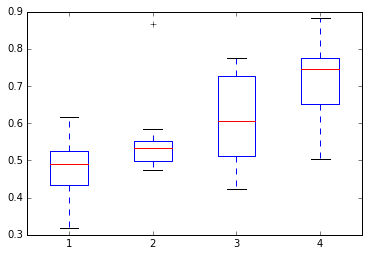

In [364]:
plt.boxplot(acc_all)
plt.show

In [365]:
np.median(SOacc)

0.48902601226833131

In [366]:
np.median(ISpec_acc)

0.53313513788021194

In [367]:
np.median(PSpec_acc)

0.6051850255273924

In [368]:
np.median(DSpec_acc)

0.74593292213429618

In [369]:
np.savetxt('resultswStairs.csv', acc_all, delimiter=',') 